<a href="https://colab.research.google.com/github/matrix-mayank/actionability-classification-teacherfeedback/blob/main/Actionability_Classification_Teacher_Feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Installing required packages**

In [3]:
# Install required packages
!pip install datasets textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.9 MB/s eta 0:00:00


## **Phase 2: Fine-tuning RoBERTa on annotated dataset**

In [ ]:
"""
Phase 2: Fine-tune RoBERTa on our annotated dataset
"""

# Import libraries
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)
import os
from datetime import datetime

# Create experiment directory with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_dir = f"experiment_{timestamp}"
os.makedirs(experiment_dir, exist_ok=True)

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check for GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load dataset
df = pd.read_csv('traindata.csv')

# Data exploration and preprocessing
print(f"Dataset shape: {df.shape}")
print(f"Label distribution: {df['label'].value_counts(normalize=True)}")

# Check for missing values
missing_values = df.isnull().sum()
print(f"Missing values:\n{missing_values}")
df = df.dropna(subset=['comment', 'label'])  # Drop rows with missing values

# Map labels to integers
label_map = {"actionable": 1, "vague": 0}
df["label"] = df["label"].map(label_map).astype(int)

# Initialize RoBERTa tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# Tokenization function with more options
def preprocess_function(examples):
    return tokenizer(
        examples['comment'],
        truncation=True,
        padding="max_length",
        max_length=512,
        return_attention_mask=True,
        return_tensors="pt"
    )

# Cross-validation setup
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_results = []
all_predictions = []
all_true_labels = []
all_fold_histories = []

for fold, (train_index, val_index) in enumerate(kf.split(df["comment"], df["label"])):
    fold_dir = f"{experiment_dir}/fold_{fold+1}"
    os.makedirs(fold_dir, exist_ok=True)

    print(f"\n{'='*50}")
    print(f"Training Fold {fold+1}/{n_splits}")
    print(f"{'='*50}")

    # Split data into train and validation set
    train_df, val_df = df.iloc[train_index], df.iloc[val_index]

    # Check label distribution in splits
    print(f"Train set shape: {train_df.shape}, Val set shape: {val_df.shape}")
    print(f"Train label distribution: {train_df['label'].value_counts(normalize=True)}")
    print(f"Val label distribution: {val_df['label'].value_counts(normalize=True)}")

    # Convert to Hugging Face Dataset
    train_dataset = Dataset.from_pandas(train_df).map(preprocess_function, batched=True)
    val_dataset = Dataset.from_pandas(val_df).map(preprocess_function, batched=True)

    # Rename label column to 'labels' for HuggingFace compatibility
    train_dataset = train_dataset.rename_column("label", "labels")
    val_dataset = val_dataset.rename_column("label", "labels")

    # Load pre-trained RoBERTa model with class weights option
    model = RobertaForSequenceClassification.from_pretrained(
        'roberta-base',
        num_labels=2,
        problem_type="single_label_classification"
    ).to(device)

    # Define training arguments with additional options
    training_args = TrainingArguments(
        output_dir=fold_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        logging_dir=f"{fold_dir}/logs",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        save_total_limit=1,
        report_to="none",
        fp16=torch.cuda.is_available(),
    )

    # Custom evaluation metric computation
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = (logits[:, 1] >= 0.6).astype(int)  # Threshold set to 0.6 to favour precision over recall
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, predictions, average='binary', zero_division=0
        )
        acc = accuracy_score(labels, predictions)

        # Store predictions and true labels for this fold
        all_predictions.extend(predictions)
        all_true_labels.extend(labels)

        return {
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }

    # Define trainer with early stopping
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Train model
    train_result = trainer.train()

    # Track training history for plots
    history = {
        'train_loss': trainer.state.log_history,
        'fold': fold + 1
    }
    all_fold_histories.append(history)

    # Save model
    trainer.save_model(f"{fold_dir}/best_model")

    # Evaluate model
    metrics = trainer.evaluate()
    print(f"Fold {fold+1} Results: {metrics}")
    fold_results.append(metrics)

    # Get predictions for this fold's validation set
    val_predictions = trainer.predict(val_dataset)

# Calculate average performance across folds
avg_results = {
    "accuracy": np.mean([res['eval_accuracy'] for res in fold_results]),
    "precision": np.mean([res['eval_precision'] for res in fold_results]),
    "recall": np.mean([res['eval_recall'] for res in fold_results]),
    "f1": np.mean([res['eval_f1'] for res in fold_results]),
    "std_f1": np.std([res['eval_f1'] for res in fold_results]),
}

print("\nFinal Cross-Validation Results:")
for metric, value in avg_results.items():
    print(f"{metric}: {value:.4f}")

# Save results to a CSV
results_df = pd.DataFrame(fold_results)
results_df.to_csv(f"{experiment_dir}/fold_results.csv", index=False)

print(f"\nAll results saved to '{experiment_dir}' directory")

Using device: cuda
Dataset shape: (662, 19)
Label distribution: label
vague         0.563444
actionable    0.436556
Name: proportion, dtype: float64
Missing values:
Unnamed: 0                    0
grade_observed                0
subject_observed              0
lesson_number                 1
class_environment             0
guide_followed_accurately     0
www                           0
ebi                           2
spm_name                      0
school_uid                    0
visit_date                    0
school_category              57
clean_www                     0
clean_ebi                     2
www_word_length               0
ebi_word_length               0
strata                        0
comment                       0
label                         0
dtype: int64

Training Fold 1/5
Train set shape: (529, 20), Val set shape: (133, 20)
Train label distribution: label
0    0.563327
1    0.436673
Name: proportion, dtype: float64
Val label distribution: label
0    0.56391
1    0

Map:   0%|          | 0/529 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-f4a7359936ab>:129: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Fold 1 Results: {'eval_loss': 0.1535666584968567, 'eval_accuracy': 0.9624060150375939, 'eval_precision': 0.9344262295081968, 'eval_recall': 0.9827586206896551, 'eval_f1': 0.957983193277311, 'eval_runtime': 0.9542, 'eval_samples_per_second': 139.388, 'eval_steps_per_second': 5.24, 'epoch': 5.0}

Training Fold 2/5
Train set shape: (529, 20), Val set shape: (133, 20)
Train label distribution: label
0    0.563327
1    0.436673
Name: proportion, dtype: float64
Val label distribution: label
0    0.56391
1    0.43609
Name: proportion, dtype: float64


Map:   0%|          | 0/529 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-f4a7359936ab>:129: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Fold 2 Results: {'eval_loss': 0.21249763667583466, 'eval_accuracy': 0.9473684210526315, 'eval_precision': 0.9047619047619048, 'eval_recall': 0.9827586206896551, 'eval_f1': 0.9421487603305785, 'eval_runtime': 0.9602, 'eval_samples_per_second': 138.519, 'eval_steps_per_second': 5.207, 'epoch': 5.0}

Training Fold 3/5
Train set shape: (530, 20), Val set shape: (132, 20)
Train label distribution: label
0    0.562264
1    0.437736
Name: proportion, dtype: float64
Val label distribution: label
0    0.568182
1    0.431818
Name: proportion, dtype: float64


Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Map:   0%|          | 0/132 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-f4a7359936ab>:129: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Fold 3 Results: {'eval_loss': 0.13304366171360016, 'eval_accuracy': 0.9696969696969697, 'eval_precision': 0.9491525423728814, 'eval_recall': 0.9824561403508771, 'eval_f1': 0.9655172413793104, 'eval_runtime': 0.9441, 'eval_samples_per_second': 139.816, 'eval_steps_per_second': 5.296, 'epoch': 5.0}

Training Fold 4/5
Train set shape: (530, 20), Val set shape: (132, 20)
Train label distribution: label
0    0.564151
1    0.435849
Name: proportion, dtype: float64
Val label distribution: label
0    0.560606
1    0.439394
Name: proportion, dtype: float64


Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Map:   0%|          | 0/132 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-f4a7359936ab>:129: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Fold 4 Results: {'eval_loss': 0.5122690200805664, 'eval_accuracy': 0.9015151515151515, 'eval_precision': 0.8571428571428571, 'eval_recall': 0.9310344827586207, 'eval_f1': 0.8925619834710744, 'eval_runtime': 0.9323, 'eval_samples_per_second': 141.592, 'eval_steps_per_second': 5.363, 'epoch': 5.0}

Training Fold 5/5
Train set shape: (530, 20), Val set shape: (132, 20)
Train label distribution: label
0    0.564151
1    0.435849
Name: proportion, dtype: float64
Val label distribution: label
0    0.560606
1    0.439394
Name: proportion, dtype: float64


Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Map:   0%|          | 0/132 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-f4a7359936ab>:129: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Fold 5 Results: {'eval_loss': 0.39464378356933594, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.873015873015873, 'eval_recall': 0.9482758620689655, 'eval_f1': 0.9090909090909091, 'eval_runtime': 0.9295, 'eval_samples_per_second': 142.012, 'eval_steps_per_second': 5.379, 'epoch': 5.0}

Final Cross-Validation Results:
accuracy: 0.9395
precision: 0.9037
recall: 0.9655
f1: 0.9335
std_f1: 0.0282

All results saved to 'experiment_20250318_001527' directory


## **Phase 3: SHAP Analysis on fine-tuned RoBERTa**

In [ ]:
"""
Phase 3: Perform SHAP analysis on the best performing fold of RoBERTA fine-tuning
"""

# Import required libraries
import pickle
import shap
from transformers import RobertaTokenizerFast, pipeline
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_fscore_support, accuracy_score

def add_shap_analysis(experiment_dir, fold=0, sample_size=250):
    print("\n=== Running SHAP Analysis ===")
    print(f"Using {sample_size} examples per class for a total of {sample_size*2} examples")

    # Create directory for SHAP results
    shap_dir = f"{experiment_dir}/shap_analysis"
    os.makedirs(shap_dir, exist_ok=True)

    # Load the saved model from the specified fold
    model_dir = f"{experiment_dir}/fold_{fold+1}/best_model"

    # Load the tokenizer
    tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

    # Create a pipeline for the specific model
    classifier = pipeline(
        "text-classification",
        model=model_dir,
        tokenizer=tokenizer,
        device=0 if torch.cuda.is_available() else -1
    )

    # Load sample data for explanation (using validation set from the fold)
    df = pd.read_csv('traindata.csv')
    label_map = {"actionable": 1, "vague": 0}
    df["label"] = df["label"].map(label_map).astype(int)

    # Get stratified sample for SHAP analysis using 250 examples per class
    actionable_count = (df['label'] == 1).sum()
    vague_count = (df['label'] == 0).sum()

    print(f"Dataset contains {actionable_count} actionable and {vague_count} vague examples")

    actionable_sample_size = min(sample_size, actionable_count)
    vague_sample_size = min(sample_size, vague_count)

    print(f"Sampling {actionable_sample_size} actionable and {vague_sample_size} vague examples")

    actionable_samples = df[df['label'] == 1].sample(n=actionable_sample_size)
    vague_samples = df[df['label'] == 0].sample(n=vague_sample_size)
    samples = pd.concat([actionable_samples, vague_samples])

    print(f"Total samples for SHAP analysis: {len(samples)}")

    # Process samples in batches to avoid memory issues
    batch_size = 50
    num_batches = (len(samples) + batch_size - 1) // batch_size

    all_shap_values = []

    for i in range(num_batches):
        print(f"Processing batch {i+1}/{num_batches}...")
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(samples))
        batch_samples = samples.iloc[start_idx:end_idx]

        # Create SHAP explainer for this batch
        explainer = shap.Explainer(
            model=lambda x: np.array([[1 - classifier(xi)[0]['score'], classifier(xi)[0]['score']] for xi in x]),
            masker=shap.maskers.Text(tokenizer)
        )

        # Get SHAP values for this batch
        print(f"Computing SHAP values for batch {i+1}...")
        batch_shap_values = explainer(batch_samples['comment'].tolist())
        all_shap_values.append(batch_shap_values)

    # Save the SHAP values from each batch
    with open(f"{shap_dir}/shap_values_batches.pkl", 'wb') as f:
        import pickle
        pickle.dump(all_shap_values, f)

    # Analyze SHAP values to find important words
    word_importance = {}

    # Process each batch
    for batch_values in all_shap_values:
        for sv in batch_values:
            for word, shap_val in zip(sv.data, sv.values[:, 1]):
                if word and word.strip():  # Skip empty tokens
                    word = word.strip()
                    if word not in word_importance:
                        word_importance[word] = []
                    word_importance[word].append(shap_val)

    # Calculate average SHAP value (and absolute value) for each word
    avg_importance = {}
    avg_abs_importance = {}

    for word, vals in word_importance.items():
        if len(vals) > 1:  # Only include words that appear multiple times
            avg_importance[word] = np.mean(vals)
            avg_abs_importance[word] = np.mean([abs(v) for v in vals])

    # Get top words for actionable class (positive values)
    top_actionable_words = sorted(
        [(word, val) for word, val in avg_importance.items() if val > 0],
        key=lambda x: x[1],
        reverse=True
    )[:50]

    # Get top words for vague class (negative values)
    top_vague_words = sorted(
        [(word, val) for word, val in avg_importance.items() if val < 0],
        key=lambda x: x[1]
    )[:50]

    # Get top words by absolute importance (regardless of direction)
    top_abs_words = sorted(
        avg_abs_importance.items(),
        key=lambda x: x[1],
        reverse=True
    )[:50]

    # Save the top words to CSV files
    pd.DataFrame(top_actionable_words, columns=['Word', 'SHAP Value']).to_csv(
        f"{shap_dir}/top_actionable_words.csv", index=False
    )

    pd.DataFrame(top_vague_words, columns=['Word', 'SHAP Value']).to_csv(
        f"{shap_dir}/top_vague_words.csv", index=False
    )

    pd.DataFrame(top_abs_words, columns=['Word', 'Absolute SHAP Value']).to_csv(
        f"{shap_dir}/top_important_words.csv", index=False
    )

    # Use the first batch for visualization
    first_batch = all_shap_values[0]

    # 1. Summary plot for the first batch
    try:
        plt.figure(figsize=(14, 10))
        shap.plots.text(first_batch[:,:,1], display=False)  # For the positive class (actionable)
        plt.title(f"SHAP Summary for 'Actionable' Class (Sample of {len(first_batch)} examples)")
        plt.tight_layout()
        plt.savefig(f"{shap_dir}/shap_summary_actionable.png", dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error generating summary plot: {e}")

    # 2. Bar plot of top influential words
    try:
        plt.figure(figsize=(12, 10))

        # Plot top 20 actionable words
        words = [word for word, _ in top_actionable_words[:20]]
        values = [val for _, val in top_actionable_words[:20]]

        plt.barh(words, values, color='forestgreen')
        plt.title('Top 20 Words Associated with Actionable Feedback')
        plt.xlabel('Average SHAP Value')
        plt.ylabel('Word')
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"{shap_dir}/top_actionable_words.png", dpi=300, bbox_inches='tight')
        plt.close()

        # Plot top 20 vague words
        plt.figure(figsize=(12, 10))

        words = [word for word, _ in top_vague_words[:20]]
        values = [abs(val) for _, val in top_vague_words[:20]]  # Make positive for better visualization

        plt.barh(words, values, color='firebrick')
        plt.title('Top 20 Words Associated with Vague Feedback')
        plt.xlabel('Average Absolute SHAP Value')
        plt.ylabel('Word')
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"{shap_dir}/top_vague_words.png", dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error generating word importance plots: {e}")

    # 3. Individual explanations for a few examples (using the first batch)
    try:
        for i in range(min(10, len(first_batch))):
            idx = samples.index[i]
            true_label = samples.loc[idx, 'label']
            comment = samples.loc[idx, 'comment']
            class_names = ['Vague', 'Actionable']

            plt.figure(figsize=(14, 6))
            shap.plots.text(first_batch[i, :, 1], display=False)
            plt.title(f"SHAP Explanation - True Label: {class_names[true_label]}")
            plt.tight_layout()
            plt.savefig(f"{shap_dir}/shap_example_{i+1}.png", dpi=300, bbox_inches='tight')
            plt.close()
    except Exception as e:
        print(f"Error generating individual explanations: {e}")

    # 4. Create an HTML report with interactive visualizations
    html_report = f"""
    <html>
    <head>
        <title>SHAP Analysis Report</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; }}
            table {{ border-collapse: collapse; width: 100%; }}
            th, td {{ text-align: left; padding: 8px; border-bottom: 1px solid #ddd; }}
            th {{ background-color: #f2f2f2; }}
            .comment {{ background-color: #f5f5f5; padding: 10px; margin: 10px 0; border-radius: 5px; }}
            .prediction {{ font-weight: bold; }}
            .highlight-pos {{ background-color: #c6efd0; padding: 2px; }}
            .highlight-neg {{ background-color: #f7c7c7; padding: 2px; }}
            img {{ max-width: 100%; }}
            .actionable {{ color: forestgreen; }}
            .vague {{ color: firebrick; }}
        </style>
    </head>
    <body>
        <h1>SHAP Analysis Report for RoBERTa Text Classification</h1>
        <p>This report shows how different parts of the text influence the model's prediction.</p>
        <p>Analysis based on {len(samples)} samples ({actionable_sample_size} actionable, {vague_sample_size} vague)</p>

        <h2>Most Influential Words for Actionable Feedback</h2>
        <table>
            <tr><th>Word</th><th>Average SHAP Value</th></tr>
    """

    # Add top actionable words to the HTML report
    for word, importance in top_actionable_words[:30]:
        html_report += f"<tr><td>{word}</td><td class='actionable'>{importance:.4f}</td></tr>"

    html_report += """
        </table>

        <h2>Most Influential Words for Vague Feedback</h2>
        <table>
            <tr><th>Word</th><th>Average SHAP Value</th></tr>
    """

    # Add top vague words to the HTML report
    for word, importance in top_vague_words[:30]:
        html_report += f"<tr><td>{word}</td><td class='vague'>{importance:.4f}</td></tr>"

    html_report += """
        </table>

        <h2>Individual Examples</h2>
    """

    # Add individual examples to the report
    for i in range(min(10, len(first_batch))):
        idx = samples.index[i]
        comment = samples.loc[idx, 'comment']
        true_label = samples.loc[idx, 'label']
        class_names = ['Vague', 'Actionable']

        # Get model prediction
        prediction = classifier(comment)[0]
        pred_label = 1 if prediction['label'] == 'LABEL_1' else 0

        html_report += f"""
        <div class="example">
            <h3>Example {i+1}</h3>
            <p><strong>True Label:</strong> {class_names[true_label]}</p>
            <p><strong>Predicted Label:</strong> {class_names[pred_label]} ({prediction['score']:.2f})</p>
            <div class="comment">{comment}</div>
            <img src="shap_example_{i+1}.png" alt="SHAP explanation">
            <hr>
        </div>
        """

    html_report += """
    </body>
    </html>
    """

    # Save the HTML report
    with open(f"{shap_dir}/shap_report.html", "w") as f:
        f.write(html_report)

    print(f"SHAP analysis completed. Results saved to {shap_dir}")
    return shap_dir

# Run SHAP analysis
if __name__ == "__main__":

    # Choose the best performing fold
    best_fold_idx = np.argmax([res['eval_f1'] for res in fold_results])

    # Run SHAP analysis on the best fold with 250 examples per class
    shap_results_dir = add_shap_analysis(experiment_dir, fold=best_fold_idx, sample_size=250)
    print(f"SHAP analysis results available at: {shap_results_dir}")


=== Running SHAP Analysis ===
Using 250 examples per class for a total of 500 examples


Device set to use cuda:0


Dataset contains 289 actionable and 373 vague examples
Sampling 250 actionable and 250 vague examples
Total samples for SHAP analysis: 500
Processing batch 1/10...
Computing SHAP values for batch 1...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 1/50 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 3/50 [00:22<03:45,  4.80s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 4/50 [00:31<05:15,  6.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 5/50 [00:42<06:08,  8.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 6/50 [00:53<06:46,  9.24s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 7/50 [01:08<07:57, 11.11s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 8/50 [01:22<08:32, 12.20s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 9/50 [01:43<10:12, 14.93s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 10/50 [01:56<09:27, 14.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 11/50 [02:15<10:10, 15.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 12/50 [02:27<09:11, 14.51s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 13/50 [02:35<07:40, 12.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 14/50 [02:50<07:57, 13.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 15/50 [03:03<07:50, 13.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 16/50 [03:13<06:58, 12.32s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 17/50 [03:23<06:19, 11.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 18/50 [03:32<05:49, 10.93s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 19/50 [03:44<05:41, 11.01s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 20/50 [03:53<05:13, 10.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 21/50 [04:02<04:56, 10.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 22/50 [04:12<04:42, 10.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 23/50 [04:22<04:28,  9.95s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 24/50 [04:31<04:15,  9.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 25/50 [04:40<04:00,  9.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 26/50 [04:50<03:50,  9.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 27/50 [05:04<04:13, 11.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 28/50 [05:18<04:22, 11.93s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 29/50 [05:34<04:35, 13.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 30/50 [05:58<05:23, 16.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 31/50 [06:12<04:57, 15.68s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 32/50 [06:21<04:06, 13.71s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 33/50 [06:31<03:33, 12.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 34/50 [06:41<03:07, 11.74s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 35/50 [06:48<02:36, 10.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 36/50 [07:06<02:58, 12.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 37/50 [07:19<02:44, 12.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 38/50 [07:29<02:21, 11.78s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 39/50 [07:39<02:03, 11.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 40/50 [07:48<01:47, 10.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 41/50 [07:57<01:32, 10.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 42/50 [08:07<01:21, 10.16s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 43/50 [08:17<01:10, 10.03s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 44/50 [08:27<00:59,  9.95s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 45/50 [08:37<00:50, 10.16s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 46/50 [08:47<00:39,  9.83s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 47/50 [08:56<00:29,  9.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 48/50 [09:06<00:19,  9.80s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 49/50 [09:16<00:09,  9.81s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer: 51it [09:26, 11.32s/it]


Processing batch 2/10...
Computing SHAP values for batch 2...


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 2/50 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 4/50 [00:29<03:55,  5.12s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 5/50 [00:38<05:16,  7.03s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 6/50 [00:48<05:55,  8.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 7/50 [00:59<06:25,  8.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 8/50 [01:07<05:59,  8.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 9/50 [01:16<06:05,  8.91s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 10/50 [01:26<06:03,  9.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 12/50 [01:39<04:50,  7.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 13/50 [01:51<05:22,  8.71s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 14/50 [02:04<06:02, 10.07s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 15/50 [02:18<06:38, 11.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 16/50 [02:36<07:29, 13.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 17/50 [02:45<06:34, 11.95s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 18/50 [02:54<06:00, 11.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 19/50 [03:04<05:32, 10.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 20/50 [03:14<05:12, 10.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 21/50 [03:23<04:55, 10.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 22/50 [03:32<04:38,  9.93s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 23/50 [03:42<04:26,  9.89s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 24/50 [03:52<04:17,  9.91s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 25/50 [04:02<04:07,  9.89s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 26/50 [04:11<03:49,  9.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 27/50 [04:23<03:59, 10.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 28/50 [04:33<03:42, 10.11s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 29/50 [04:43<03:30, 10.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 30/50 [04:52<03:18,  9.94s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 31/50 [05:02<03:08,  9.91s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 32/50 [05:12<02:58,  9.91s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 33/50 [05:21<02:45,  9.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 35/50 [05:35<01:59,  7.96s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 36/50 [05:44<01:57,  8.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 38/50 [05:58<01:28,  7.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 39/50 [06:08<01:28,  8.03s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 40/50 [06:16<01:22,  8.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 41/50 [06:26<01:18,  8.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 42/50 [06:36<01:11,  8.98s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 43/50 [06:45<01:03,  9.03s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 44/50 [06:55<00:55,  9.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 45/50 [07:04<00:46,  9.36s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 46/50 [07:11<00:34,  8.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 47/50 [07:21<00:26,  8.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 48/50 [07:30<00:18,  9.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 49/50 [07:40<00:09,  9.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 50/50 [07:50<00:00,  9.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 51it [07:59,  9.80s/it]


Processing batch 3/10...
Computing SHAP values for batch 3...


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 2/50 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 4/50 [00:28<03:45,  4.89s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 5/50 [00:38<05:07,  6.84s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 6/50 [00:47<05:46,  7.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 7/50 [00:56<05:55,  8.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 8/50 [01:06<06:05,  8.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 9/50 [01:16<06:10,  9.03s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 10/50 [01:26<06:11,  9.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 11/50 [01:35<06:07,  9.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 12/50 [01:45<05:55,  9.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 13/50 [01:54<05:50,  9.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 14/50 [02:04<05:43,  9.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 15/50 [02:14<05:34,  9.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 16/50 [02:23<05:27,  9.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 17/50 [02:32<05:12,  9.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 18/50 [02:42<05:04,  9.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 19/50 [02:52<04:54,  9.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 20/50 [03:01<04:46,  9.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 21/50 [03:11<04:37,  9.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 22/50 [03:20<04:24,  9.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 23/50 [03:29<04:14,  9.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 24/50 [03:39<04:07,  9.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 25/50 [03:49<03:59,  9.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 26/50 [03:58<03:49,  9.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 27/50 [04:07<03:36,  9.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 28/50 [04:17<03:28,  9.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 29/50 [04:27<03:21,  9.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 30/50 [04:37<03:12,  9.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 31/50 [04:46<03:03,  9.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 32/50 [04:56<02:51,  9.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 33/50 [05:05<02:42,  9.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 34/50 [05:15<02:33,  9.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 35/50 [05:25<02:25,  9.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 36/50 [05:34<02:15,  9.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 37/50 [05:44<02:04,  9.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 38/50 [05:53<01:55,  9.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 40/50 [06:05<01:13,  7.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 41/50 [06:15<01:12,  8.00s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 42/50 [06:23<01:05,  8.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 43/50 [06:33<00:59,  8.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 44/50 [06:42<00:52,  8.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 45/50 [06:52<00:45,  9.02s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 46/50 [07:01<00:36,  9.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 47/50 [07:11<00:28,  9.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 48/50 [07:21<00:18,  9.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 49/50 [07:30<00:09,  9.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 50/50 [07:40<00:00,  9.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 51it [07:49,  9.59s/it]


Processing batch 4/10...
Computing SHAP values for batch 4...


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 2/50 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 4/50 [00:28<03:25,  4.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 5/50 [00:37<04:56,  6.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 7/50 [00:49<04:05,  5.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 8/50 [00:58<04:54,  7.02s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 9/50 [01:08<05:20,  7.83s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 10/50 [01:17<05:33,  8.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 11/50 [01:27<05:38,  8.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 12/50 [01:37<05:41,  8.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 13/50 [01:46<05:39,  9.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 14/50 [01:56<05:34,  9.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 15/50 [02:05<05:26,  9.33s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 16/50 [02:10<04:33,  8.05s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 17/50 [02:20<04:42,  8.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 18/50 [02:29<04:41,  8.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 19/50 [02:39<04:37,  8.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 20/50 [02:48<04:33,  9.12s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 21/50 [02:58<04:28,  9.24s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 22/50 [03:07<04:23,  9.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 23/50 [03:17<04:13,  9.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 24/50 [03:26<04:02,  9.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 25/50 [03:36<03:54,  9.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 26/50 [03:45<03:47,  9.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 27/50 [03:55<03:39,  9.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 28/50 [04:04<03:27,  9.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 29/50 [04:14<03:18,  9.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 30/50 [04:23<03:11,  9.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 31/50 [04:33<03:02,  9.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 32/50 [04:43<02:53,  9.62s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 33/50 [04:50<02:32,  8.95s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 34/50 [05:00<02:26,  9.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 35/50 [05:10<02:19,  9.32s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 36/50 [05:19<02:11,  9.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 38/50 [05:34<01:35,  7.94s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 39/50 [05:43<01:33,  8.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 40/50 [05:53<01:28,  8.82s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 41/50 [06:01<01:17,  8.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 42/50 [06:11<01:11,  8.94s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 43/50 [06:21<01:04,  9.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 44/50 [06:30<00:55,  9.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 45/50 [06:39<00:46,  9.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 46/50 [06:49<00:37,  9.35s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 47/50 [06:59<00:28,  9.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 48/50 [07:08<00:19,  9.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 49/50 [07:18<00:09,  9.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 50/50 [07:27<00:00,  9.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 51it [07:36,  9.32s/it]


Processing batch 5/10...
Computing SHAP values for batch 5...


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 2/50 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 4/50 [00:28<03:40,  4.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 5/50 [00:38<05:00,  6.68s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 6/50 [00:47<05:39,  7.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 7/50 [00:57<06:06,  8.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 8/50 [01:07<06:12,  8.88s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 9/50 [01:17<06:14,  9.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 10/50 [01:26<06:08,  9.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 11/50 [01:35<05:52,  9.03s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 12/50 [01:44<05:50,  9.22s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 13/50 [01:50<05:04,  8.24s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 14/50 [02:00<05:08,  8.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 15/50 [02:09<05:11,  8.91s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 16/50 [02:19<05:09,  9.12s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 17/50 [02:29<05:06,  9.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 18/50 [02:38<04:56,  9.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 19/50 [02:47<04:48,  9.31s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 20/50 [02:57<04:42,  9.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 21/50 [03:07<04:36,  9.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 22/50 [03:16<04:27,  9.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 23/50 [03:26<04:16,  9.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 24/50 [03:35<04:06,  9.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 25/50 [03:45<03:58,  9.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 26/50 [03:54<03:50,  9.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 27/50 [04:03<03:35,  9.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 28/50 [04:12<03:24,  9.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 29/50 [04:22<03:16,  9.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 30/50 [04:31<03:08,  9.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 31/50 [04:41<03:00,  9.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 32/50 [04:51<02:51,  9.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 33/50 [05:00<02:39,  9.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 34/50 [05:09<02:31,  9.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 35/50 [05:19<02:22,  9.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 36/50 [05:29<02:14,  9.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 37/50 [05:38<02:04,  9.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 38/50 [05:48<01:53,  9.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 39/50 [05:57<01:44,  9.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 40/50 [06:07<01:35,  9.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 41/50 [06:17<01:27,  9.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 42/50 [06:26<01:17,  9.68s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 43/50 [06:36<01:06,  9.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 44/50 [06:45<00:57,  9.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 45/50 [06:55<00:48,  9.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 46/50 [07:05<00:38,  9.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 47/50 [07:14<00:28,  9.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 48/50 [07:23<00:18,  9.48s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 49/50 [07:31<00:08,  8.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 50/50 [07:41<00:00,  9.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 51it [07:50,  9.61s/it]


Processing batch 6/10...
Computing SHAP values for batch 6...


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 2/50 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 4/50 [00:29<03:43,  4.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 5/50 [00:38<05:08,  6.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 6/50 [00:48<05:46,  7.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 7/50 [00:57<05:57,  8.32s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 8/50 [01:07<06:07,  8.75s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 9/50 [01:12<05:11,  7.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 10/50 [01:21<05:26,  8.15s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 13/50 [01:39<03:50,  6.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 14/50 [01:48<04:19,  7.20s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 15/50 [01:54<03:58,  6.82s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 16/50 [02:03<04:19,  7.63s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 17/50 [02:10<03:59,  7.25s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 18/50 [02:17<03:51,  7.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 19/50 [02:27<04:07,  7.98s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 21/50 [02:40<03:25,  7.09s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 22/50 [02:48<03:27,  7.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 23/50 [02:58<03:34,  7.96s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 24/50 [03:07<03:37,  8.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 25/50 [03:17<03:39,  8.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 26/50 [03:26<03:36,  9.04s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 27/50 [03:32<03:06,  8.10s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 28/50 [03:42<03:08,  8.56s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 29/50 [03:49<02:52,  8.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 31/50 [04:00<02:01,  6.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 32/50 [04:08<02:01,  6.78s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 33/50 [04:16<02:01,  7.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 35/50 [04:30<01:43,  6.88s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 36/50 [04:37<01:37,  6.95s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 38/50 [04:47<01:11,  5.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 39/50 [04:57<01:16,  6.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 40/50 [05:06<01:16,  7.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 42/50 [05:18<00:52,  6.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 43/50 [05:28<00:52,  7.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 45/50 [05:41<00:34,  6.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 46/50 [05:51<00:30,  7.66s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 47/50 [05:57<00:21,  7.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 48/50 [06:06<00:15,  7.78s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 49/50 [06:16<00:08,  8.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 50/50 [06:25<00:00,  8.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 51it [06:35,  8.06s/it]


Processing batch 7/10...
Computing SHAP values for batch 7...


  0%|          | 0/342 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 2/50 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 4/50 [00:21<02:35,  3.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 5/50 [00:31<04:24,  5.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 6/50 [00:40<05:19,  7.26s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 7/50 [00:47<04:57,  6.93s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 8/50 [00:55<05:18,  7.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 9/50 [01:03<05:11,  7.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 10/50 [01:13<05:27,  8.19s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 11/50 [01:20<05:06,  7.85s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 13/50 [01:31<04:02,  6.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 14/50 [01:40<04:25,  7.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 15/50 [01:50<04:42,  8.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 16/50 [01:59<04:50,  8.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 17/50 [02:08<04:46,  8.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 18/50 [02:16<04:31,  8.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 19/50 [02:26<04:32,  8.80s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 20/50 [02:35<04:30,  9.01s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 21/50 [02:44<04:20,  8.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 22/50 [02:53<04:10,  8.95s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 23/50 [03:03<04:07,  9.16s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 24/50 [03:12<04:01,  9.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 25/50 [03:22<03:54,  9.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 28/50 [03:38<02:20,  6.37s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 29/50 [03:45<02:18,  6.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 30/50 [03:54<02:28,  7.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 31/50 [04:04<02:32,  8.03s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 32/50 [04:13<02:32,  8.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 33/50 [04:23<02:30,  8.83s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 34/50 [04:32<02:22,  8.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 35/50 [04:42<02:16,  9.09s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 36/50 [04:51<02:08,  9.21s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 37/50 [04:57<01:48,  8.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 38/50 [05:07<01:43,  8.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 39/50 [05:16<01:37,  8.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 40/50 [05:26<01:30,  9.05s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 41/50 [05:35<01:22,  9.20s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 42/50 [05:43<01:10,  8.80s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 43/50 [05:53<01:03,  9.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 44/50 [06:02<00:55,  9.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 45/50 [06:11<00:45,  9.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 46/50 [06:21<00:37,  9.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 47/50 [06:29<00:26,  8.84s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 48/50 [06:38<00:18,  9.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 49/50 [06:48<00:09,  9.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 50/50 [06:57<00:00,  9.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 51it [07:05,  8.69s/it]


Processing batch 8/10...
Computing SHAP values for batch 8...


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 2/50 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 4/50 [00:21<03:36,  4.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 5/50 [00:31<04:58,  6.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 6/50 [00:40<05:39,  7.71s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 7/50 [00:49<05:51,  8.18s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 9/50 [00:58<03:59,  5.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 10/50 [01:08<04:40,  7.00s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 11/50 [01:17<05:04,  7.80s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 12/50 [01:26<05:14,  8.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 13/50 [01:36<05:15,  8.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 14/50 [01:45<05:18,  8.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 15/50 [01:55<05:18,  9.11s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 16/50 [02:04<05:13,  9.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 17/50 [02:13<05:03,  9.20s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 19/50 [02:28<04:06,  7.95s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 20/50 [02:37<04:06,  8.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 22/50 [02:49<03:10,  6.82s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 23/50 [02:57<03:19,  7.39s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 24/50 [03:04<03:02,  7.04s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 26/50 [03:15<02:28,  6.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 27/50 [03:22<02:30,  6.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 29/50 [03:34<02:01,  5.80s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 30/50 [03:43<02:17,  6.90s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 31/50 [03:53<02:25,  7.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 32/50 [04:02<02:27,  8.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 33/50 [04:11<02:23,  8.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 34/50 [04:21<02:20,  8.78s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 35/50 [04:29<02:06,  8.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 36/50 [04:38<02:03,  8.82s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 37/50 [04:47<01:55,  8.87s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 38/50 [04:53<01:35,  8.00s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 39/50 [05:03<01:33,  8.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 40/50 [05:12<01:26,  8.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 41/50 [05:21<01:18,  8.68s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 42/50 [05:29<01:08,  8.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 43/50 [05:38<01:01,  8.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 44/50 [05:47<00:52,  8.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 45/50 [05:56<00:43,  8.77s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 47/50 [06:08<00:22,  7.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 49/50 [06:20<00:06,  6.33s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 50/50 [06:30<00:00,  7.27s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer: 51it [06:36,  8.09s/it]


Processing batch 9/10...
Computing SHAP values for batch 9...


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 2/50 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 4/50 [00:26<02:53,  3.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 5/50 [00:35<04:25,  5.89s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 6/50 [00:44<05:18,  7.24s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 7/50 [00:52<05:12,  7.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 8/50 [00:59<05:02,  7.20s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 9/50 [01:08<05:24,  7.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 10/50 [01:18<05:38,  8.45s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 11/50 [01:25<05:19,  8.20s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 12/50 [01:34<05:21,  8.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 13/50 [01:44<05:24,  8.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 14/50 [01:54<05:23,  9.00s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 16/50 [02:07<04:19,  7.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 17/50 [02:15<04:14,  7.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 18/50 [02:24<04:22,  8.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 19/50 [02:33<04:21,  8.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 20/50 [02:41<04:06,  8.20s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 23/50 [02:59<02:50,  6.33s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 24/50 [03:08<03:09,  7.27s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 26/50 [03:20<02:32,  6.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 27/50 [03:29<02:48,  7.32s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 28/50 [03:39<02:55,  7.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 30/50 [03:53<02:28,  7.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 31/50 [04:03<02:33,  8.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 32/50 [04:12<02:32,  8.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 33/50 [04:21<02:26,  8.62s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 34/50 [04:27<02:05,  7.83s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 35/50 [04:36<02:04,  8.31s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 36/50 [04:46<01:59,  8.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 40/50 [05:02<00:45,  4.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 41/50 [05:11<00:53,  5.90s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 42/50 [05:20<00:55,  6.89s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 43/50 [05:29<00:50,  7.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 44/50 [05:38<00:47,  7.96s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 45/50 [05:48<00:42,  8.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 47/50 [05:58<00:19,  6.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 48/50 [06:08<00:14,  7.35s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 50/50 [06:19<00:00,  6.20s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 51it [06:29,  7.95s/it]


Processing batch 10/10...
Computing SHAP values for batch 10...


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 2/50 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 4/50 [00:27<03:24,  4.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 6/50 [00:39<03:43,  5.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 7/50 [00:47<04:17,  5.98s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 9/50 [01:00<04:05,  5.99s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 10/50 [01:09<04:43,  7.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 11/50 [01:19<05:05,  7.83s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 12/50 [01:28<05:10,  8.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 13/50 [01:37<05:18,  8.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 14/50 [01:47<05:19,  8.88s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 15/50 [01:56<05:16,  9.05s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 17/50 [02:09<04:10,  7.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 18/50 [02:19<04:21,  8.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 20/50 [02:32<03:31,  7.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 22/50 [02:43<02:49,  6.04s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 23/50 [02:49<02:41,  5.99s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 24/50 [02:59<03:03,  7.06s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 25/50 [03:05<02:50,  6.83s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 26/50 [03:11<02:36,  6.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 27/50 [03:21<02:51,  7.45s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 28/50 [03:27<02:36,  7.09s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 29/50 [03:36<02:44,  7.82s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 33/50 [03:53<01:19,  4.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 34/50 [04:02<01:36,  6.01s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 35/50 [04:12<01:45,  7.06s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 36/50 [04:19<01:40,  7.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 37/50 [04:28<01:41,  7.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 38/50 [04:38<01:38,  8.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 39/50 [04:47<01:34,  8.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 40/50 [04:57<01:28,  8.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 42/50 [05:07<00:54,  6.75s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 44/50 [05:19<00:36,  6.08s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 45/50 [05:25<00:29,  5.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 47/50 [05:37<00:17,  5.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 48/50 [05:47<00:13,  6.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 49/50 [05:56<00:07,  7.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 50/50 [06:05<00:00,  8.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 51it [06:15,  7.65s/it]


SHAP analysis completed. Results saved to experiment_20250318_001527/shap_analysis
SHAP analysis results available at: experiment_20250318_001527/shap_analysis


## **Phase 4a: Making predictions on the full dataset**

Using device: cuda
Data loaded with 13118 rows
Loading tokenizer and model...
Preparing dataset...
Making predictions on 13118 samples...


Predicting: 100%|██████████| 410/410 [05:26<00:00,  1.26it/s]


Predictions saved to predictions_results.csv

Prediction Summary:
predicted_label
vague         6854
actionable    6264
Name: count, dtype: int64
Visualizations saved to PNG files


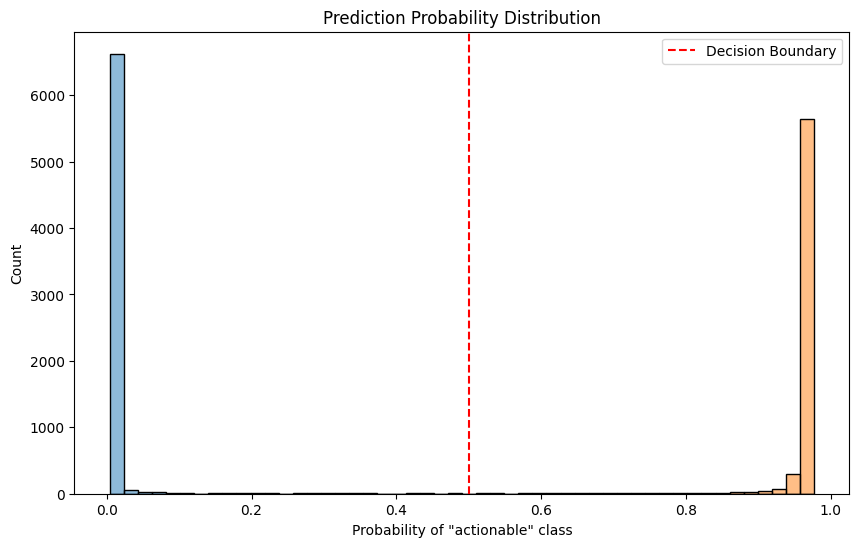

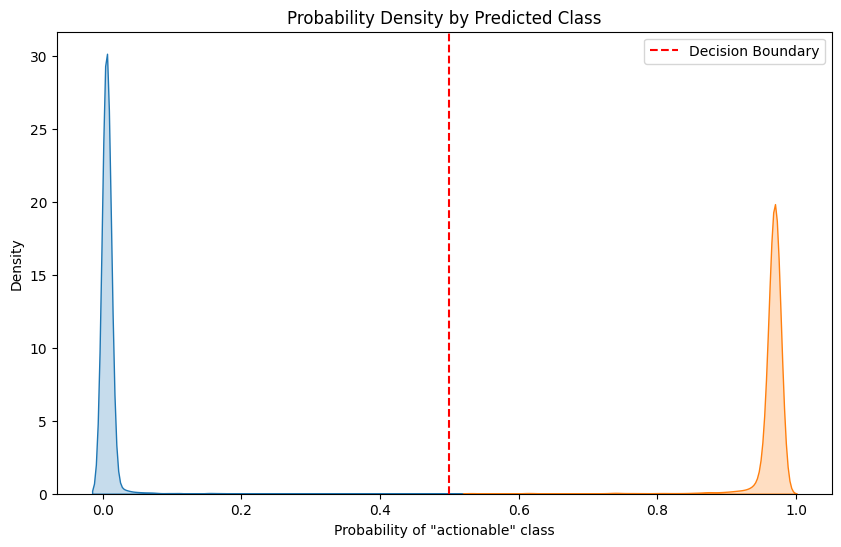

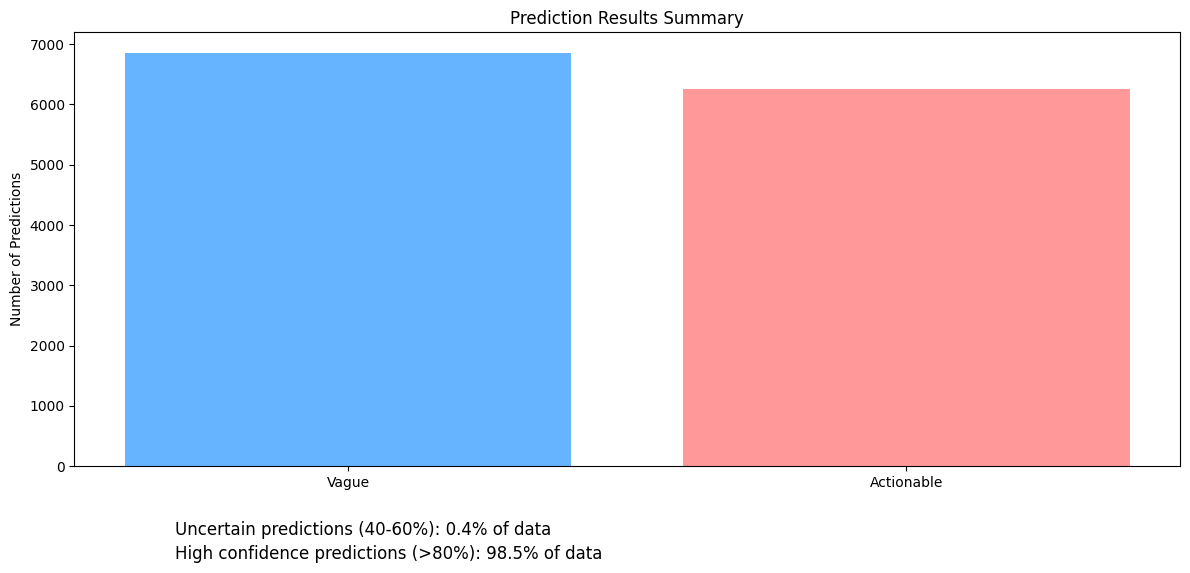

In [ ]:
"""
Phase 4a: Make predictions on the rest of the dataset"
"""

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Import the dataset with comments to be classified
df = pd.read_csv('tobepredicted.csv')

# Combine comments to be classified
df['comment'] = df['clean_www'] + ' ' + df['clean_ebi']
prediction_df = df

MODEL_PATH = "experiment_20250318_001527/fold_3/best_model"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

print(f"Data loaded with {len(prediction_df)} rows")

# Create a custom dataset for efficient processing
class CommentDataset(Dataset):
    def __init__(self, comments, tokenizer, max_length=512):
        self.comments = comments
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        comment = str(self.comments[idx])
        inputs = self.tokenizer(
            comment,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Squeeze tensors to remove batch dimension added by tokenizer
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze()
        }

def predict_in_batches(model, dataset, batch_size=32):
    """Make predictions using batches for efficiency"""
    dataloader = DataLoader(dataset, batch_size=batch_size)
    predictions = []
    probabilities = []

    model.eval()

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Get predicted class (0 or 1)
            batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(batch_preds)

            # Get probabilities using softmax
            probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
            probabilities.extend(probs[:, 1])  # Probability of class 1 (actionable)

    return predictions, probabilities

def main():
    print("Loading tokenizer and model...")
    # Load tokenizer and model
    tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_PATH)
    model = RobertaForSequenceClassification.from_pretrained(MODEL_PATH).to(device)

    print("Preparing dataset...")
    dataset = CommentDataset(prediction_df['comment'].values, tokenizer)

    print(f"Making predictions on {len(dataset)} samples...")
    # Make predictions
    predictions, probabilities = predict_in_batches(model, dataset)

    # Map predictions back to labels
    label_map_reverse = {0: "vague", 1: "actionable"}
    prediction_labels = [label_map_reverse[pred] for pred in predictions]

    # Add predictions to dataframe
    prediction_df['predicted_label'] = prediction_labels  # String labels (vague/actionable)
    prediction_df['predicted_class'] = predictions  # Binary class (0/1)
    prediction_df['prob_vague'] = [1-p for p in probabilities]  # Probability of class 0 (vague)
    prediction_df['prob_actionable'] = probabilities  # Probability of class 1 (actionable)

    # Save results
    output_path = 'predictions_results.csv'
    prediction_df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")

    # Generate a summary of predictions
    print("\nPrediction Summary:")
    print(prediction_df['predicted_label'].value_counts())

    try:
        import matplotlib.pyplot as plt
        import seaborn as sns

        # Probability Distribution
        plt.figure(figsize=(10, 6))
        sns.histplot(data=prediction_df, x='prob_actionable', hue='predicted_label', bins=50)
        plt.title('Prediction Probability Distribution')
        plt.xlabel('Probability of "actionable" class')
        plt.ylabel('Count')
        plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Boundary')
        plt.legend()
        plt.savefig('prediction_probability_distribution.png', dpi=300, bbox_inches='tight')

        # Probability Density by Class
        plt.figure(figsize=(10, 6))
        sns.kdeplot(data=prediction_df, x='prob_actionable', hue='predicted_label', fill=True)
        plt.title('Probability Density by Predicted Class')
        plt.xlabel('Probability of "actionable" class')
        plt.ylabel('Density')
        plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Boundary')
        plt.legend()
        plt.savefig('prediction_probability_density.png', dpi=300, bbox_inches='tight')

        # Create a dual-axis visualization showing confidence levels
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # High confidence predictions (>0.8 or <0.2)
        high_conf = prediction_df[(prediction_df['prob_actionable'] > 0.8) |
                                 (prediction_df['prob_actionable'] < 0.2)]

        # Medium confidence predictions (0.4-0.6)
        medium_conf = prediction_df[(prediction_df['prob_actionable'] >= 0.4) &
                                   (prediction_df['prob_actionable'] <= 0.6)]

        # Calculate percentages
        high_conf_pct = len(high_conf) / len(prediction_df) * 100
        medium_conf_pct = len(medium_conf) / len(prediction_df) * 100

        # Count by class
        labels = ['Vague', 'Actionable']
        vague_counts = [sum(prediction_df['predicted_class'] == 0),
                        sum(prediction_df['predicted_class'] == 1)]

        ax1.bar(labels, vague_counts, color=['#66b3ff', '#ff9999'])
        ax1.set_ylabel('Number of Predictions')
        ax1.set_title('Prediction Results Summary')

        # Add confidence information as text
        plt.figtext(0.15, 0.01, f"High confidence predictions (>80%): {high_conf_pct:.1f}% of data",
                   fontsize=12, ha='left')
        plt.figtext(0.15, 0.05, f"Uncertain predictions (40-60%): {medium_conf_pct:.1f}% of data",
                   fontsize=12, ha='left')

        plt.tight_layout(rect=[0, 0.1, 1, 0.95])
        plt.savefig('prediction_summary.png', dpi=300, bbox_inches='tight')

        print("Visualizations saved to PNG files")
    except Exception as e:
        print(f"Could not generate visualizations: {e}")

if __name__ == "__main__":
    main()

## **Phase 4b: Retaining only "high-confidence" predictions**

In [ ]:
"""
Phase 4b: Retain only "high-confidence" predictions"
"""

CONFIDENCE_THRESHOLD = 0.9

prediction_df['confidence'] = prediction_df.apply(
    lambda row: max(row['prob_vague'], row['prob_actionable']), axis=1
)

# Filter out low confidence predictions
high_confidence_df = prediction_df[prediction_df['confidence'] >= CONFIDENCE_THRESHOLD].copy()

print(f"Original dataset: {len(prediction_df)} predictions")
print(f"After filtering low confidence: {len(high_confidence_df)} predictions")
print(f"Removed {len(prediction_df) - len(high_confidence_df)} low confidence predictions ({(len(prediction_df) - len(high_confidence_df)) / len(prediction_df) * 100:.1f}% of data)")

high_confidence_df.to_csv('predictions_results_high_confidence.csv', index=False)

filtered_csv_path = 'predictions_high_confidence.csv'
high_confidence_df.to_csv(filtered_csv_path, index=False)

from google.colab import files

files.download(filtered_csv_path)

Original dataset: 13118 predictions
After filtering low confidence: 12789 predictions
Removed 329 low confidence predictions (2.5% of data)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Phase 5: Analysing linguistic features of the classified observations**

In [6]:
"""
Phase 5: Analyse linguistic features of the classified observations
"""

# Import required libraries

import textstat
import re
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

predicted = pd.read_csv("predictions_high_confidence.csv")

try:
    import spacy
    nlp = spacy.load('en_core_web_sm')
    spacy_available = True
    print("spaCy model loaded successfully")
except:
    spacy_available = False
    print("spaCy model not available. Using NLTK for part-of-speech tagging.")

def analyze_specific_text_features(df, text_column='comment', label_column='predicted_label', prob_column='prob_actionable'):
    """
    Analyze only the specified linguistic features of text based on actionability
    """
    print("Analyzing specific linguistic features of feedback...")

    # Create a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()

    # Handle missing values in the text column
    missing_mask = df_copy[text_column].isna() | (df_copy[text_column] == '')
    print(f"Found {missing_mask.sum()} rows with missing text values.")
    df_copy = df_copy[~missing_mask].copy()

    # Ensure text column contains strings
    df_copy[text_column] = df_copy[text_column].astype(str)

    # Ensure label column is binary
    if df_copy[label_column].dtype == 'object':
        df_copy['binary_label'] = df_copy[label_column].map({'actionable': 1, 'vague': 0})
    else:
        df_copy['binary_label'] = df_copy[label_column]

    # Create dataframe to hold text metrics
    text_metrics = pd.DataFrame()
    text_metrics['comment'] = df_copy[text_column]
    text_metrics['label'] = df_copy['binary_label']
    text_metrics['probability'] = df_copy[prob_column]

    def safe_tokenize_words(text):
        """Safely tokenize text into words"""
        try:
            # Simple word tokenization without NLTK in case of errors
            if not nltk.data.find('tokenizers/punkt'):
                return text.split()
            return word_tokenize(text)
        except:
            return text.split()

    def safe_tokenize_sentences(text):
        """Safely tokenize text into sentences"""
        try:
            if not nltk.data.find('tokenizers/punkt'):
                return [s.strip() for s in re.split(r'[.!?]+', text) if s.strip()]
            return sent_tokenize(text)
        except:
            return [s.strip() for s in re.split(r'[.!?]+', text) if s.strip()]

    # 1. Word Count
    print("Calculating word count...")
    text_metrics['word_count'] = text_metrics['comment'].apply(
        lambda x: max(1, len(safe_tokenize_words(x)))
    )

    # For verb density and imperative density, we need sentence count
    text_metrics['sentence_count'] = text_metrics['comment'].apply(
        lambda x: max(1, len(safe_tokenize_sentences(x)))
    )

    # 2. Readability metrics
    print("Calculating readability metrics...")

    def safe_readability(text, method):
        try:
            return method(text)
        except:
            return np.nan

    text_metrics['flesch_reading_ease'] = text_metrics['comment'].apply(
        lambda x: safe_readability(x, textstat.flesch_reading_ease)
    )
    text_metrics['flesch_kincaid_grade'] = text_metrics['comment'].apply(
        lambda x: safe_readability(x, textstat.flesch_kincaid_grade)
    )
    text_metrics['gunning_fog'] = text_metrics['comment'].apply(
        lambda x: safe_readability(x, textstat.gunning_fog)
    )

    # 3. Lexical diversity
    print("Calculating lexical diversity...")

    def safe_lexical_diversity(text):
        try:
            words = [w.lower() for w in safe_tokenize_words(text) if w.isalpha()]
            if not words:
                return 0
            return len(set(words)) / len(words)
        except:
            return 0

    text_metrics['lexical_diversity'] = text_metrics['comment'].apply(safe_lexical_diversity)

    # Safe version of number density
    def safe_density(numerator, denominator):
        return numerator / denominator if denominator > 0 else 0

    # 4. POS tagging - Adjective Count, Adverb Count, Modifier Count
    print("Calculating parts of speech metrics...")

    if spacy_available:
        def count_pos(text, pos_list):
            try:
                doc = nlp(text[:min(len(text), 100000)])  # Limit text length for spaCy
                return sum(1 for token in doc if token.pos_ in pos_list)
            except:
                return 0

        text_metrics['adjective_count'] = text_metrics['comment'].apply(
            lambda x: count_pos(x, ["ADJ"])
        )
        text_metrics['adverb_count'] = text_metrics['comment'].apply(
            lambda x: count_pos(x, ["ADV"])
        )
        text_metrics['modifier_count'] = text_metrics['adjective_count'] + text_metrics['adverb_count']

        # 5. Verb Density
        def count_verbs(text):
            try:
                doc = nlp(text[:min(len(text), 100000)])  # Limit text length for spaCy
                return sum(1 for token in doc if token.pos_ == "VERB")
            except:
                return 0

        text_metrics['verb_count'] = text_metrics['comment'].apply(count_verbs)
        text_metrics['verb_density'] = text_metrics.apply(
            lambda row: safe_density(row['verb_count'], row['word_count']), axis=1
        )
    else:
        # Fallback to simplistic regex-based approximations if spaCy isn't available
        print("spaCy not available, using simpler approximations...")

        # Adjectives often end with these suffixes
        adj_suffixes = ['able', 'al', 'ary', 'ful', 'ic', 'ical', 'ish', 'ive', 'less', 'ous', 'y']

        # Adverbs often end with 'ly'
        adv_suffixes = ['ly']

        def count_approx_adjectives(text):
            words = [w.lower() for w in safe_tokenize_words(text) if w.isalpha()]
            return sum(1 for w in words if any(w.endswith(suffix) for suffix in adj_suffixes))

        def count_approx_adverbs(text):
            words = [w.lower() for w in safe_tokenize_words(text) if w.isalpha()]
            return sum(1 for w in words if any(w.endswith(suffix) for suffix in adv_suffixes))

        text_metrics['adjective_count'] = text_metrics['comment'].apply(count_approx_adjectives)
        text_metrics['adverb_count'] = text_metrics['comment'].apply(count_approx_adverbs)
        text_metrics['modifier_count'] = text_metrics['adjective_count'] + text_metrics['adverb_count']

        # Simple verb approximation using common verb endings
        def count_verbs_approx(text):
            try:
                verb_endings = ['ing', 'ed', 'es', 's', 'ate', 'ize', 'ise', 'ify']
                words = [w.lower() for w in safe_tokenize_words(text) if w.isalpha()]

                verb_count = 0
                for word in words:
                    if any(word.endswith(ending) for ending in verb_endings):
                        verb_count += 1

                return verb_count
            except:
                return 0

        text_metrics['verb_count'] = text_metrics['comment'].apply(count_verbs_approx)
        text_metrics['verb_density'] = text_metrics.apply(
            lambda row: safe_density(row['verb_count'], row['word_count']), axis=1
        )

    # 6. Imperative sentences
    print("Checking for imperative sentences...")

    def safe_imperatives(text):
        try:
            sentences = safe_tokenize_sentences(text)
            imperative_count = 0

            # Simple heuristic: Sentences starting with a verb
            for sentence in sentences:
                words = safe_tokenize_words(sentence)
                if words and words[0].lower() in ['do', 'make', 'try', 'use', 'go', 'ensure', 'start',
                                                 'stop', 'avoid', 'consider', 'add', 'remove', 'check']:
                    imperative_count += 1

            return imperative_count
        except:
            return 0

    text_metrics['imperative_count'] = text_metrics['comment'].apply(safe_imperatives)
    text_metrics['imperative_density'] = text_metrics.apply(
        lambda row: safe_density(row['imperative_count'], row['sentence_count']), axis=1
    )

    return text_metrics

def calculate_cohens_d(group1, group2):
    """
    Calculate Cohen's d effect size between two groups
    """
    # Remove NaNs
    group1 = group1.dropna()
    group2 = group2.dropna()

    # Check if we have enough data
    if len(group1) < 2 or len(group2) < 2:
        return np.nan

    # Calculate means
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)

    # Calculate standard deviations
    sd1 = np.std(group1, ddof=1)  # ddof=1 for sample standard deviation
    sd2 = np.std(group2, ddof=1)

    # Calculate pooled standard deviation
    n1, n2 = len(group1), len(group2)
    pooled_sd = np.sqrt(((n1 - 1) * sd1**2 + (n2 - 1) * sd2**2) / (n1 + n2 - 2))

    # Calculate Cohen's d
    if pooled_sd == 0:  # Avoid division by zero
        return np.nan

    d = (mean1 - mean2) / pooled_sd
    return d

def interpret_cohens_d(d):
    """
    Interpret Cohen's d effect size
    """
    if np.isnan(d):
        return "N/A"

    abs_d = abs(d)

    if abs_d < 0.01:
        return "Very small"
    elif abs_d < 0.2:
        return "Small"
    elif abs_d < 0.5:
        return "Medium"
    elif abs_d < 0.8:
        return "Large"
    elif abs_d < 1.2:
        return "Very large"
    else:
        return "Extremely large"

def create_statistical_comparison_table(text_metrics):
    """
    Create a comprehensive statistical comparison table with mean, SD, t-statistic, p-values, and effect sizes
    """
    print("\nCreating statistical comparison table with effect sizes...")

    # Define only the specific metrics we want to analyze
    metrics_to_analyze = [
        'word_count',
        'flesch_reading_ease',
        'flesch_kincaid_grade',
        'gunning_fog',
        'lexical_diversity',
        'adjective_count',
        'adverb_count',
        'modifier_count',
        'verb_density',
        'imperative_density'
    ]

    # Create binary groups
    actionable = text_metrics[text_metrics['label'] == 1]
    non_actionable = text_metrics[text_metrics['label'] == 0]

    # Prepare results dataframe
    results = []

    for metric in metrics_to_analyze:
        # Create display name with first letter capitalized and underscores replaced
        display_name = ' '.join(word.capitalize() for word in metric.split('_'))

        # Calculate statistics
        a_data = actionable[metric].dropna()
        na_data = non_actionable[metric].dropna()

        actionable_mean = a_data.mean()
        actionable_sd = a_data.std()
        nonactionable_mean = na_data.mean()
        nonactionable_sd = na_data.std()

        # Calculate Cohen's d effect size
        cohens_d = calculate_cohens_d(a_data, na_data)
        effect_size_interpret = interpret_cohens_d(cohens_d)

        # Calculate t-statistic and p-value if we have sufficient data
        if len(a_data) > 5 and len(na_data) > 5:
            # Independent t-test
            t_stat, p_value_t = ttest_ind(a_data, na_data, equal_var=False)

            # Mann-Whitney U test (non-parametric alternative)
            u_stat, p_value_u = mannwhitneyu(a_data, na_data, alternative='two-sided')

            # Use Mann-Whitney p-value as default since it doesn't assume normality
            p_value = p_value_u
            test_statistic = u_stat
            test_name = "Mann-Whitney U"
        else:
            t_stat = np.nan
            p_value = np.nan
            test_statistic = np.nan
            test_name = "Insufficient data"

        # Add to results
        results.append({
            'Metric': display_name,
            'Actionable Mean': round(actionable_mean, 3),
            'Actionable SD': round(actionable_sd, 3),
            'Non-Actionable Mean': round(nonactionable_mean, 3),
            'Non-Actionable SD': round(nonactionable_sd, 3),
            'Test Statistic': round(test_statistic, 3) if not np.isnan(test_statistic) else np.nan,
            'Test': test_name,
            'p-value': round(p_value, 5) if not np.isnan(p_value) else np.nan,
            'Significant': p_value < 0.05 if not np.isnan(p_value) else False,
            "Cohen's d": round(cohens_d, 3) if not np.isnan(cohens_d) else np.nan,
            'Effect Size': effect_size_interpret
        })

    # Create DataFrame
    results_df = pd.DataFrame(results)

    # Add asterisks to significant metrics
    results_df['Significance'] = ''
    results_df.loc[results_df['p-value'] < 0.05, 'Significance'] = '*'
    results_df.loc[results_df['p-value'] < 0.01, 'Significance'] = '**'
    results_df.loc[results_df['p-value'] < 0.001, 'Significance'] = '***'

    return results_df

def format_table_for_publication(results_df):
    """Format the results table for publication/presentation with effect sizes"""
    # Create a copy to avoid modifying the original
    formatted_df = results_df.copy()

    # Format p-values
    formatted_df['p-value'] = formatted_df['p-value'].apply(
        lambda x: f"<.001{formatted_df.loc[formatted_df['p-value']==x, 'Significance'].values[0]}" if x < 0.001 else
        (f"{x:.3f}{formatted_df.loc[formatted_df['p-value']==x, 'Significance'].values[0]}" if not np.isnan(x) else "N/A")
    )

    # Format means and SDs as "Mean (SD)"
    formatted_df['Actionable'] = formatted_df.apply(
        lambda row: f"{row['Actionable Mean']} ({row['Actionable SD']})", axis=1
    )

    formatted_df['Non-Actionable'] = formatted_df.apply(
        lambda row: f"{row['Non-Actionable Mean']} ({row['Non-Actionable SD']})", axis=1
    )

    # Format test statistic
    formatted_df['Test Statistic'] = formatted_df['Test Statistic'].apply(
        lambda x: f"{x:.3f}" if not np.isnan(x) else "N/A"
    )

    # Format Cohen's d
    formatted_df["Cohen's d"] = formatted_df["Cohen's d"].apply(
        lambda x: f"{x:.3f}" if not np.isnan(x) else "N/A"
    )

    # Select and reorder columns for final table
    final_table = formatted_df[['Metric', 'Actionable', 'Non-Actionable',
                               'Test', 'Test Statistic', 'p-value',
                               "Cohen's d", 'Effect Size']]

    return final_table

def analyze_feedback_linguistics(df, text_column='comment', label_column='predicted_label', prob_column='prob_actionable'):
    """
    Run a linguistic analysis on specific feedback text features with statistical comparison and effect sizes
    """
    print(f"Starting analysis with {len(df)} feedback entries...")

    text_metrics = analyze_specific_text_features(df, text_column, label_column, prob_column)

    # Statistical comparison table with effect sizes
    results_df = create_statistical_comparison_table(text_metrics)

    # Format table
    final_table = format_table_for_publication(results_df)

    # Display formatted table
    print("\nStatistical Comparison of Linguistic Features Between Actionable and Non-Actionable Feedback:")
    print(final_table)

    # Save detailed results to CSV
    results_df.to_csv('linguistic_feature_detailed_comparison.csv', index=False)
    final_table.to_csv('linguistic_feature_formatted_table.csv', index=False)

    print("\nAnalysis complete! Results saved to CSV files.")
    return text_metrics, results_df, final_table

# Run the analysis
text_metrics, results, final_table = analyze_feedback_linguistics(predicted)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


spaCy model loaded successfully
Starting analysis with 12789 feedback entries...
Analyzing specific linguistic features of feedback...
Found 31 rows with missing text values.
Calculating word count...
Calculating readability metrics...
Calculating lexical diversity...
Calculating parts of speech metrics...
Checking for imperative sentences...

Creating statistical comparison table with effect sizes...

Statistical Comparison of Linguistic Features Between Actionable and Non-Actionable Feedback:
                 Metric       Actionable   Non-Actionable            Test  \
0            Word Count  41.335 (20.226)  27.064 (13.548)  Mann-Whitney U   
1   Flesch Reading Ease  29.495 (21.476)  43.029 (20.584)  Mann-Whitney U   
2  Flesch Kincaid Grade   19.418 (7.519)    13.96 (5.303)  Mann-Whitney U   
3           Gunning Fog   21.072 (7.879)   15.741 (5.691)  Mann-Whitney U   
4     Lexical Diversity    0.813 (0.087)    0.844 (0.094)  Mann-Whitney U   
5       Adjective Count     2.44 (1.85

## **Phase 6: Examining actionability differences across grades and subjects**

In [7]:
"""
Phase 6: Perform chi-square tests between the label column and categorical variables
"""

def perform_chi_square_analysis(df, label_column='predicted_label', categorical_columns=['subject_observed', 'grade_observed']):

    print("\nPerforming chi-square analysis between labels and categorical variables...")

    # Create a copy to avoid modifying the original dataframe
    df_copy = df.copy()

    # Ensure label column is properly formatted
    if df_copy[label_column].dtype == 'object':
        df_copy['binary_label'] = df_copy[label_column].map({'actionable': 1, 'vague': 0})
    else:
        df_copy['binary_label'] = df_copy[label_column]

    # Convert binary label to categorical label for clarity in results
    df_copy['label_cat'] = df_copy['binary_label'].map({1: 'Actionable', 0: 'Vague'})

    results = []

    for cat_col in categorical_columns:
        print(f"Analyzing {cat_col}...")

        # Check if column exists
        if cat_col not in df_copy.columns:
            print(f"Warning: Column '{cat_col}' not found in dataframe.")
            continue

        # Remove missing values
        valid_data = df_copy.dropna(subset=[cat_col, 'label_cat'])

        # Create contingency table
        contingency_table = pd.crosstab(valid_data['label_cat'], valid_data[cat_col])

        # Perform chi-square test
        try:
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)

            # Calculate Cramer's V
            n = contingency_table.sum().sum()
            min_dim = min(contingency_table.shape) - 1
            cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else np.nan

            # Create descriptive string for interpretation
            if cramers_v < 0.1:
                effect_size = "Negligible"
            elif cramers_v < 0.2:
                effect_size = "Weak"
            elif cramers_v < 0.3:
                effect_size = "Moderate"
            else:
                effect_size = "Strong"

            # Calculate percentages for each category split by label
            category_counts = contingency_table.copy()
            row_pcts = category_counts.div(category_counts.sum(axis=1), axis=0) * 100

            # Find categories with largest differences between actionable and vague feedback
            if 'Actionable' in row_pcts.index and 'Vague' in row_pcts.index:
                differences = abs(row_pcts.loc['Actionable'] - row_pcts.loc['Vague'])
                top_diff_categories = differences.nlargest(3).index.tolist()
                top_diff_categories_str = ", ".join(str(c) for c in top_diff_categories)
            else:
                top_diff_categories_str = "N/A"

            # Determine significance level
            if p_value < 0.001:
                significance = "***"
            elif p_value < 0.01:
                significance = "**"
            elif p_value < 0.05:
                significance = "*"
            else:
                significance = ""

            # Add to results
            results.append({
                'Variable': cat_col,
                'Chi-Square': round(chi2, 3),
                'p-value': p_value,
                'p-value_formatted': f"{p_value:.5f}{significance}",
                'Degrees of Freedom': dof,
                "Cramer's V": round(cramers_v, 3),
                'Effect Size': effect_size,
                'Significant': p_value < 0.05,
                'N': n,
                'Top Different Categories': top_diff_categories_str
            })

            # Create visualizations of the contingency table
            try:
                # Normalize to get percentages
                normalized_table = pd.DataFrame(
                    contingency_table.values / contingency_table.sum(axis=1).values.reshape(-1, 1) * 100,
                    index=contingency_table.index,
                    columns=contingency_table.columns
                )

                # Plot heat map
                plt.figure(figsize=(12, 8))
                sns.heatmap(normalized_table, annot=True, fmt='.1f', cmap='YlGnBu')
                plt.title(f'Distribution of {cat_col} by Feedback Type (%)')
                plt.ylabel('Feedback Type')
                plt.xlabel(f'{cat_col}')
                plt.tight_layout()
                plt.savefig(f'chi_square_{cat_col}_heatmap.png', dpi=300, bbox_inches='tight')
                plt.close()

                print(f"Visualization saved as chi_square_{cat_col}_heatmap.png")
            except Exception as e:
                print(f"Could not create visualization: {e}")

        except Exception as e:
            print(f"Error performing chi-square test for {cat_col}: {e}")

    # Create DataFrame from results
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('p-value')

        # Save detailed results to CSV
        results_df.to_csv('chi_square_results.csv', index=False)

        # Create a publication-ready table
        publication_table = results_df[['Variable', 'Chi-Square', 'p-value_formatted',
                                      'Degrees of Freedom', "Cramer's V", 'Effect Size',
                                      'N', 'Top Different Categories']]
        publication_table.columns = ['Variable', 'Chi-Square', 'p-value',
                                   'df', "Cramer's V", 'Effect Size',
                                   'N', 'Categories with Largest Differences']

        publication_table.to_csv('chi_square_publication_table.csv', index=False)

        return results_df, publication_table
    else:
        print("No results to report.")
        return None, None

chi_square_results, publication_table = perform_chi_square_analysis(predicted)

if publication_table is not None:
    print("\nChi-Square Test Results:")
    print(publication_table)
    print("\nSaved results to chi_square_results.csv and chi_square_publication_table.csv")


Performing chi-square analysis between labels and categorical variables...
Analyzing subject_observed...
Could not create visualization: name 'plt' is not defined
Analyzing grade_observed...
Could not create visualization: name 'plt' is not defined

Chi-Square Test Results:
           Variable  Chi-Square     p-value  df  Cramer's V Effect Size  \
1    grade_observed     155.657  0.00000***   5       0.110        Weak   
0  subject_observed      35.120  0.00000***   3       0.052  Negligible   

       N Categories with Largest Differences  
1  12789           Grade 5, Grade 6, Grade 4  
0  12789           Math, FasterMath, Reading  

Saved results to chi_square_results.csv and chi_square_publication_table.csv
